In [1]:
!python -V

Python 3.9.16


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error



In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("NYC_Taxi")



<Experiment: artifact_location='./mlruns/1', creation_time=1684942754265, experiment_id='1', last_update_time=1684942754265, lifecycle_stage='active', name='NYC_Taxi', tags={}>

In [5]:
df = pd.read_parquet('/home/brandon/MLOps Zoomcamp/yellow_tripdata_2022-01.parquet')

In [6]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [7]:
df.columns.value_counts()

VendorID                 1
fare_amount              1
congestion_surcharge     1
total_amount             1
improvement_surcharge    1
tolls_amount             1
tip_amount               1
mta_tax                  1
extra                    1
payment_type             1
tpep_pickup_datetime     1
DOLocationID             1
PULocationID             1
store_and_fwd_flag       1
RatecodeID               1
trip_distance            1
passenger_count          1
tpep_dropoff_datetime    1
airport_fee              1
dtype: int64

In [8]:
df.tpep_pickup_datetime = pd.to_datetime(df['tpep_pickup_datetime'])
df.tpep_dropoff_datetime = pd.to_datetime(df['tpep_dropoff_datetime'])

In [9]:
df['duration'] = df.tpep_dropoff_datetime -df.tpep_pickup_datetime

In [10]:
td = df.duration.iloc[0]

In [11]:
td.total_seconds() / 60

17.816666666666666

In [12]:
df.duration.apply(lambda td: td.total_seconds() / 60)

0          17.816667
1           8.400000
2           8.966667
3          10.033333
4          37.533333
             ...    
2463926     5.966667
2463927    10.650000
2463928    11.000000
2463929    12.050000
2463930    27.000000
Name: duration, Length: 2463931, dtype: float64

In [13]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,0 days 00:17:49
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,0 days 00:08:24
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,0 days 00:08:58
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,0 days 00:10:02
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,0 days 00:37:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN,0 days 00:05:58
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN,0 days 00:10:39
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN,0 days 00:11:00
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN,0 days 00:12:03


/tmp/ipykernel_16899/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

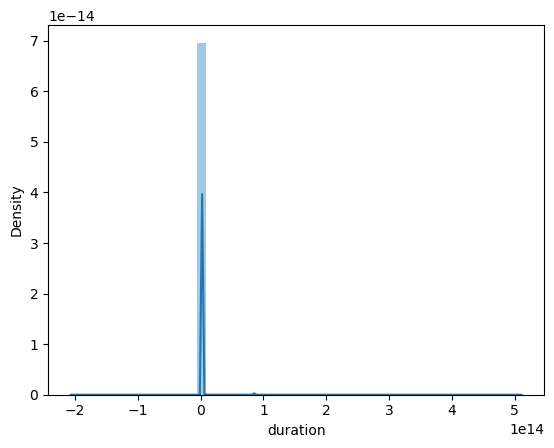

In [14]:
sns.distplot(df.duration)

In [15]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count                      2463931
mean     0 days 00:14:12.732175129
std      0 days 00:46:26.718308266
min              -3 days +14:37:36
50%                0 days 00:10:11
95%                0 days 00:31:56
98%                0 days 00:42:09
99%                0 days 00:50:51
max                5 days 21:53:11
Name: duration, dtype: object

In [16]:
df = df[(df.duration >= '0 days 01:00:00') & (df.duration <= '0 days 60:00:00')]

In [17]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
70,2,2022-01-01 00:31:12,2022-01-02 00:00:58,1.0,3.03,1.0,N,79,261,2,15.00,0.5,0.5,0.00,0.00,0.3,18.80,2.5,0.0,0 days 23:29:46
481,2,2022-01-01 00:15:34,2022-01-01 01:29:42,6.0,16.21,1.0,N,161,134,1,60.50,0.5,0.5,14.17,6.55,0.3,85.02,2.5,0.0,0 days 01:14:08
575,2,2022-01-01 00:17:11,2022-01-01 23:52:41,1.0,1.48,1.0,N,142,48,1,10.50,0.5,0.5,0.00,0.00,0.3,14.30,2.5,0.0,0 days 23:35:30
1050,2,2022-01-01 00:35:28,2022-01-02 00:03:07,1.0,4.73,1.0,N,142,125,2,19.00,0.5,0.5,0.00,0.00,0.3,22.80,2.5,0.0,0 days 23:27:39
1368,2,2022-01-01 00:53:25,2022-01-02 00:50:13,1.0,3.02,1.0,N,68,45,1,13.00,0.5,0.5,4.20,0.00,0.3,21.00,2.5,0.0,0 days 23:56:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463360,6,2022-01-31 19:01:10,2022-01-31 20:01:37,NaN,4.71,NaN,None,265,42,0,16.75,0.0,0.5,0.00,0.00,0.3,17.55,NaN,NaN,0 days 01:00:27
2463361,6,2022-01-31 19:01:34,2022-01-31 20:01:41,NaN,7.60,NaN,None,265,152,0,24.43,0.0,0.5,0.00,0.00,0.3,25.23,NaN,NaN,0 days 01:00:07
2463532,6,2022-01-31 20:01:41,2022-01-31 21:01:55,NaN,11.08,NaN,None,265,69,0,43.20,0.0,0.5,0.00,0.00,0.3,44.00,NaN,NaN,0 days 01:00:14
2463557,6,2022-01-31 20:01:03,2022-01-31 21:01:59,NaN,7.63,NaN,None,265,76,0,45.20,0.0,0.5,0.00,0.00,0.3,46.00,NaN,NaN,0 days 01:00:56


In [18]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']


In [19]:
df[categorical] = df[categorical].astype('str')

/tmp/ipykernel_16899/790595652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype('str')


In [20]:
df[categorical].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [21]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [22]:
dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)

In [23]:
x_train

<12564x477 sparse matrix of type '<class 'numpy.float64'>'
	with 37692 stored elements in Compressed Sparse Row format>

In [24]:
target = 'duration'
y_train = df[target].values

In [25]:
y_train

array([84586000000000,  4448000000000, 84930000000000, ...,
        3614000000000,  3656000000000,  7233000000000],
      dtype='timedelta64[ns]')

In [26]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [27]:
y_pred = lr.predict(x_train)

/tmp/ipykernel_16899/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_16899/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


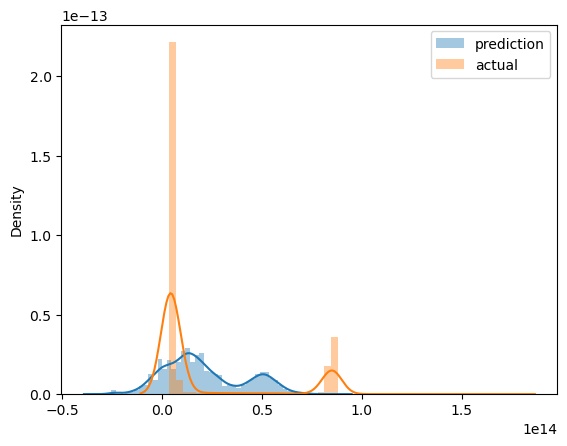

In [28]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [29]:


# Convert timedelta values to numerical representations (seconds)
y_train_seconds = pd.to_timedelta(y_train).total_seconds()
y_pred_seconds = pd.to_timedelta(y_pred).total_seconds()

# Calculate mean squared error
mse = mean_squared_error(y_train_seconds, y_pred_seconds, squared=False)





In [30]:
#Print MSE
print(mse)


24680.621154481505


In [31]:
lasso = Lasso(alpha=1.0)
lasso.fit(x_train, y_train)

y_pred = lasso.predict(x_train)

/home/brandon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6240282873365766e+30, tolerance: 1.259629306361064e+27
  model = cd_fast.sparse_enet_coordinate_descent(


In [32]:
#Put all previous code into a function
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.tpep_dropoff_datetime = pd.to_datetime(df['tpep_dropoff_datetime'])
    df.tpep_pickup_datetime = pd.to_datetime(df['tpep_pickup_datetime'])
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 0) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype('str')
    
    return df

In [33]:
df_train = read_dataframe('/home/brandon/MLOps Zoomcamp/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('/home/brandon/MLOps Zoomcamp/yellow_tripdata_2022-02.parquet')

In [34]:
len(df_train), len(df_val)

(2450090, 2950274)

In [35]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
x_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
x_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_val)

mse = mean_squared_error(y_val, y_pred, squared=False)

In [36]:
#Print MSE

print(mse)

8.075883222380945


In [37]:
lasso = Lasso(alpha=1.0)
lasso.fit(x_train, y_train)

y_pred = lasso.predict(x_val)

mse = mean_squared_error(y_val, y_pred, squared=False)

In [38]:
#Print MSE

print(mse)

9.756305201183736


In [39]:
ridge = Ridge(alpha=1.0)
ridge.fit(x_train, y_train)

y_pred = ridge.predict(x_val)

mse = mean_squared_error(y_val, y_pred, squared=False)

In [40]:
#Print MSE

print(mse)

8.118532073900516


In [41]:
#try pick up and drop off location as a feature

df_train['PU_DO'] = df_train.PULocationID + '_' + df_train.DOLocationID
df_val['PU_DO'] = df_val.PULocationID + '_' + df_val.DOLocationID

In [42]:
df_val

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration,PU_DO
0,1,2022-02-01 00:06:58,2022-02-01 00:19:24,1.0,5.40,1.0,N,138,252,1,...,1.75,0.5,3.90,0.00,0.3,23.45,0.0,1.25,12.433333,138_252
1,1,2022-02-01 00:38:22,2022-02-01 00:55:55,1.0,6.40,1.0,N,138,41,2,...,1.75,0.5,0.00,6.55,0.3,30.10,0.0,1.25,17.550000,138_41
2,1,2022-02-01 00:03:20,2022-02-01 00:26:59,1.0,12.50,1.0,N,138,200,2,...,1.75,0.5,0.00,6.55,0.3,44.60,0.0,1.25,23.650000,138_200
3,2,2022-02-01 00:08:00,2022-02-01 00:28:05,1.0,9.88,1.0,N,239,200,2,...,0.50,0.5,0.00,3.00,0.3,34.80,2.5,0.00,20.083333,239_200
4,2,2022-02-01 00:06:48,2022-02-01 00:33:07,1.0,12.16,1.0,N,138,125,1,...,0.50,0.5,8.11,0.00,0.3,48.66,2.5,1.25,26.316667,138_125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2979426,2,2022-02-28 23:50:00,2022-03-01 00:06:00,NaN,3.40,NaN,None,163,193,0,...,0.00,0.5,0.00,0.00,0.3,17.67,NaN,NaN,16.000000,163_193
2979427,2,2022-02-28 23:06:57,2022-02-28 23:19:12,NaN,3.48,NaN,None,141,4,0,...,0.00,0.5,2.00,0.00,0.3,19.81,NaN,NaN,12.250000,141_4
2979428,2,2022-02-28 23:48:13,2022-03-01 00:03:33,NaN,3.05,NaN,None,161,151,0,...,0.00,0.5,3.81,0.00,0.3,21.49,NaN,NaN,15.333333,161_151
2979429,2,2022-02-28 23:56:41,2022-03-01 00:04:57,NaN,2.62,NaN,None,141,226,0,...,0.00,0.5,1.71,0.00,0.3,17.54,NaN,NaN,8.266667,141_226


In [43]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
x_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
x_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_val)

mse = mean_squared_error(y_val, y_pred, squared=False)

In [44]:
#Print MSE

print(mse)

5.643390923134876


In [45]:
with mlflow.start_run():
    
    mlflow.set_tag('model', 'linear regression')
    mlflow.set_tag('developer', 'brandon')
    mlflow.log_param('train_data_path', '/home/brandon/MLOps Zoomcamp/yellow_tripdata_2022-01.parquet')
    mlflow.log_param('val_data_path', '/home/brandon/MLOps Zoomcamp/yellow_tripdata_2022-02.parquet')
    
    alpha = 1.0
    mlflow.log_param('alpha', alpha)
    
    lasso = Lasso(alpha)
    lasso.fit(x_train, y_train)

    y_pred = lasso.predict(x_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

In [46]:
#Print MSE

print(mse)

5.643390923134876


In [47]:
with mlflow.start_run():
    
    mlflow.set_tag('model', 'Ridge Regression')
    mlflow.set_tag('developer', 'brandon')
    mlflow.log_param('train_data_path', '/home/brandon/MLOps Zoomcamp/yellow_tripdata_2022-01.parquet')
    mlflow.log_param('val_data_path', '/home/brandon/MLOps Zoomcamp/yellow_tripdata_2022-02.parquet')
    
    alpha = 0.5
    mlflow.log_param('alpha', alpha)

    ridge = Ridge(alpha)
    ridge.fit(x_train, y_train)

    y_pred = ridge.predict(x_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)
    
    mlflow.log_artifact('model1.bin', artifact_path='model_pickle')

In [48]:
#Print MSE

print(mse)

5.643390923134876


In [49]:
#save model
with open('model1.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [50]:
df_train = df_train.sample(n=20_000, random_state=1)

In [52]:
#Add XGBoost Models

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

In [53]:
train = xgb.DMatrix(x_train, label=y_train)
valid = xgb.DMatrix(x_val, label=y_val)

In [54]:
print("Train data shape:", x_train.shape)
print("Train labels shape:", y_train.shape)
print("Validation data shape:", x_val.shape)
print("Validation labels shape:", y_val.shape)


Train data shape: (2450090, 20776)
Train labels shape: (2450090,)
Validation data shape: (2950274, 20776)
Validation labels shape: (2950274,)


In [55]:
import pandas as pd
import numpy as np

# Assuming x_train is a numpy array
x_train = pd.DataFrame(x_train)

# Checking for missing values in training data
missing_values_train = x_train.isnull().sum()
print("Missing values in training data:")
print(missing_values_train)

# Assuming x_val is a numpy array
x_val = pd.DataFrame(x_val)

# Checking for missing values in validation data
missing_values_valid = x_val.isnull().sum()
print("Missing values in validation data:")
print(missing_values_valid)




Missing values in training data:
0    0
dtype: int64
Missing values in validation data:
0    0
dtype: int64


In [56]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag('model', 'XGBoost')
        mlflow.set_tag('developer', 'brandon')
        mlflow.log_params(params)
        
        mlflow.xgboost.autolog(disable= True)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=30,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10)
        
        y_pred = booster.predict(x_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
        
    return {'loss': rmse, 'status': STATUS_OK}
  

In [57]:
import pandas as pd
import xgboost as xgb
import hyperopt as hp
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp
from sklearn.metrics import mean_squared_error
import numpy as np

# Define search space
search_space = {
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42,
}

# Define the objective function
def objective(params):
    # Convert max_depth to integer
    params['max_depth'] = int(params['max_depth'])

    # Train the model with the given parameters
    model = xgb.train(params, train, verbose_eval=True)
    # Perform evaluation on the validation data
    predictions = model.predict(valid)
    rmse = np.sqrt(mean_squared_error(y_val, predictions))
    return {'loss': rmse, 'status': STATUS_OK}

# Run hyperparameter optimization
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_result)






100%|██████████| 10/10 [15:37<00:00, 93.73s/trial, best loss: 5.110551818782536] 
Best Hyperparameters:
{'learning_rate': 0.8510748706554431, 'max_depth': 78.0, 'min_child_weight': 2.8554195665299282, 'reg_alpha': 0.029875313029814114, 'reg_lambda': 0.021279100049027527}


In [65]:
import xgboost as xgb
from hyperopt import fmin, tpe, Trials

# Define search space
search_space = {
    'learning_rate': 0.39413453377376984,
    'max_depth': 41,
    'reg_alpha': 0.011225289108518981,
    'reg_lambda': 0.050637175400720935,
    'min_child_weight': 14.1671199968075,
    'objective': 'reg:squarederror',
    'seed': 42,
}

# Run the model with best parameters
booster = xgb.train(
    params=search_space,
    dtrain=train,
    num_boost_round=30,
    evals=[(valid, 'validation')],
    early_stopping_rounds=10
)

# ... (rest of the code)

# Run hyperparameter optimization
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_result)


[0]	validation-rmse:11.14304
[1]	validation-rmse:8.25672
[2]	validation-rmse:6.73289
[3]	validation-rmse:5.96145
[4]	validation-rmse:5.57131
[5]	validation-rmse:5.36896
[6]	validation-rmse:5.25915
[7]	validation-rmse:5.19562
[8]	validation-rmse:5.15800
[9]	validation-rmse:5.13390
[10]	validation-rmse:5.12005
[11]	validation-rmse:5.11101
[12]	validation-rmse:5.10697
[13]	validation-rmse:5.10353
[14]	validation-rmse:5.10037
[15]	validation-rmse:5.09603
[16]	validation-rmse:5.09382
[17]	validation-rmse:5.09188
[18]	validation-rmse:5.08985
[19]	validation-rmse:5.08825
[20]	validation-rmse:5.08656
[21]	validation-rmse:5.08489
[22]	validation-rmse:5.08293
[23]	validation-rmse:5.08045
[24]	validation-rmse:5.07809
[25]	validation-rmse:5.07680
[26]	validation-rmse:5.07529
[27]	validation-rmse:5.07400
[28]	validation-rmse:5.07285
[29]	validation-rmse:5.07146
100%|██████████| 10/10 [12:09<00:00, 72.95s/trial, best loss: 5.133901194260357]
Best Hyperparameters:
{}


In [59]:
logged_model = 'runs:/a1463d2d8974477db5afba630316cd3a/models'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



In [60]:
loaded_model 

mlflow.pyfunc.loaded_model:
  artifact_path: models
  flavor: mlflow.xgboost
  run_id: a1463d2d8974477db5afba630316cd3a

In [61]:
xgboost_model = mlflow.xgboost.load_model(logged_model) 

In [62]:
xgboost_model

In [63]:
y_pred = xgboost_model.predict(valid)

In [64]:
y_pred[:10]

array([14.763157 , 19.215132 , 26.539064 , 23.863781 , 31.039145 ,
       14.531641 , 24.47528  ,  5.4276433, 18.482895 , 16.208553 ],
      dtype=float32)

In [66]:
from mlflow.tracking import MlflowClient

MLFLOW_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_URI)

In [67]:
client.list_experiments()

/tmp/ipykernel_16899/849364539.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_experiments`` is deprecated. This method will be removed in a future release. Use ``search_experiments()`` instead.
  client.list_experiments()


[<Experiment: artifact_location='./mlruns/1', creation_time=1684942754265, experiment_id='1', last_update_time=1684942754265, lifecycle_stage='active', name='NYC_Taxi', tags={}>]

In [75]:
client.create_experiment(name="NYC_Taxi_2")

'2'

In [76]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids=1,   
    filter_string="metrics.rmse < 6.8",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"])

In [77]:
for run in runs: 
    print("run_id:", run.info.run_id, "| rmse:", run.data.metrics["rmse"], "| alpha:", run.data.params["alpha"])

run_id: 0481f053af584df59a9b5f14297ef2e5 | rmse: 6.072645374458907 | alpha: 0.5
run_id: 88d81d4d77ca40b08eb9308217534dce | rmse: 6.072645374458907 | alpha: 0.5
run_id: db6c9d75efc34c09986305d00594046d | rmse: 6.072645374458907 | alpha: 0.5
run_id: 8910f88c63bf49778dd453716480c2b8 | rmse: 6.072645374458907 | alpha: 0.5
run_id: 989d7934c2704f6c9d431a13cf54008c | rmse: 6.072645374458907 | alpha: 0.5


In [78]:
import mlflow 

mlflow.set_tracking_uri(MLFLOW_URI)

In [80]:
run_id = "0481f053af584df59a9b5f14297ef2e5"
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name="NYC_Taxi_2")

Successfully registered model 'NYC_Taxi_2'.
2023/05/30 12:29:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: NYC_Taxi_2, version 1
Created version '1' of model 'NYC_Taxi_2'.


<ModelVersion: creation_timestamp=1685438985520, current_stage='None', description=None, last_updated_timestamp=1685438985520, name='NYC_Taxi_2', run_id='0481f053af584df59a9b5f14297ef2e5', run_link=None, source='./mlruns/1/0481f053af584df59a9b5f14297ef2e5/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [81]:
model_uri

'runs:/0481f053af584df59a9b5f14297ef2e5/model'

In [82]:
client.list_registered_models()

/tmp/ipykernel_16899/1629620035.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.list_registered_models`` is deprecated. This method will be removed in a future release. Use ``search_registered_models()`` instead.
  client.list_registered_models()


[<RegisteredModel: creation_timestamp=1685435280424, description='', last_updated_timestamp=1685435707026, latest_versions=[<ModelVersion: creation_timestamp=1685435282625, current_stage='Staging', description='', last_updated_timestamp=1685435707026, name='NYC Taxi Regression', run_id='a1463d2d8974477db5afba630316cd3a', run_link='', source='./mlruns/1/a1463d2d8974477db5afba630316cd3a/artifacts/models', status='READY', status_message=None, tags={}, user_id=None, version=1>], name='NYC Taxi Regression', tags={}>,
 <RegisteredModel: creation_timestamp=1685438985105, description=None, last_updated_timestamp=1685438985520, latest_versions=[<ModelVersion: creation_timestamp=1685438985520, current_stage='None', description=None, last_updated_timestamp=1685438985520, name='NYC_Taxi_2', run_id='0481f053af584df59a9b5f14297ef2e5', run_link=None, source='./mlruns/1/0481f053af584df59a9b5f14297ef2e5/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>], name='NYC

In [90]:
model_name = "NYC Taxi Regression"
client.get_latest_versions(name=model_name)

[<ModelVersion: creation_timestamp=1685435282625, current_stage='Staging', description='', last_updated_timestamp=1685435707026, name='NYC Taxi Regression', run_id='a1463d2d8974477db5afba630316cd3a', run_link='', source='./mlruns/1/a1463d2d8974477db5afba630316cd3a/artifacts/models', status='READY', status_message=None, tags={}, user_id=None, version=1>]

In [92]:
staged_model = "NYC_Taxi_2"
client.transition_model_version_stage(
    name=staged_model,
    version=1,
    stage="Staging",
)

<ModelVersion: creation_timestamp=1685438985520, current_stage='Staging', description=None, last_updated_timestamp=1685439638929, name='NYC_Taxi_2', run_id='0481f053af584df59a9b5f14297ef2e5', run_link=None, source='./mlruns/1/0481f053af584df59a9b5f14297ef2e5/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [93]:
client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="Production",
    archive_existing_versions=True)   

<ModelVersion: creation_timestamp=1685435282625, current_stage='Production', description='', last_updated_timestamp=1685439646255, name='NYC Taxi Regression', run_id='a1463d2d8974477db5afba630316cd3a', run_link='', source='./mlruns/1/a1463d2d8974477db5afba630316cd3a/artifacts/models', status='READY', status_message=None, tags={}, user_id=None, version=1>